In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy import data
from torchtext.legacy.data import Field, BucketIterator, Iterator


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np
import pandas as pd

import random
import math
import time

import pickle
import nlpaug
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.char as nac
import nlpaug.flow.sequential as naf

from nltk.tokenize.treebank import TreebankWordDetokenizer

from wordcloud import WordCloud, STOPWORDS

import re
from tokenize import tokenize, untokenize
import io
from nltk.corpus import stopwords
from rouge_score import rouge_scorer

from nltk.translate.bleu_score import sentence_bleu
import nltk
import plotly.express as px
import seaborn as sns

from tqdm import tqdm

In [2]:
nlp = spacy.load("en_core_web_sm")

In [3]:
df = pd.read_excel("ABAP_NEW_V1.xlsx")

In [4]:
df.shape

(300, 2)

In [5]:
df.dtypes

Pseudo Code               object
ABAP(HANA) source code    object
dtype: object

In [6]:
df.size

600

In [7]:
df

,Pseudo Code,ABAP(HANA) source code
0,Read from internal table lt_mara to get the data,read table lt_mara from data(ls_data).\nIf sy-...
1,Fetch data from ZMARA using inner join ZMAKTX ...,select * from zmara inner join zmaktx on zmakt...
2,Read data from internal table lt_vbap,read table lt_vbap from data(ls_data).\nIf sy-...
3,Move data of one table to another table,move-corresponding lt_tab1 to lt_tab2.
4,loop over internal table lt_cust to get the data,loop at lt_cust into data(ls_data).\nEndloop.
...,...,...
295,check lt_data exists or not,if lt_data is not initial.\nendif.
296,"concatenate 2 variables separated by ','","data(lv_val) = |{ lv_value1 },{ lv_value 2}|."
297,Create selection screen with paramaeter.,SELECTION-SCREEN BEGIN OF BLOCK rad1 WITH FRAM...
298,Read dataset from AL11 path,OPEN DATASET dset FOR OUTPUT IN BINARY MODE.\n...


In [8]:
df_new = pd.DataFrame()

for j in df['ABAP(HANA) source code']:
    val = str(j).lower()
    
 
    if 'select' in val:
        df1  = pd.DataFrame({"ABAP":[val],"Category":['fetch']})
        df_new = df_new.append(df1, ignore_index = True)  
    elif 'read' in val:
        df1  = pd.DataFrame({"ABAP":[val],"Category":['Read']})
        df_new = df_new.append(df1, ignore_index = True)  
    elif 'object' in val:
        df1  = pd.DataFrame({"ABAP":[val],"Category":['object']})
        df_new = df_new.append(df1, ignore_index = True)  
    elif 'delete' in val:
        df1  = pd.DataFrame({"ABAP":[val],"Category":['delete']})
        df_new = df_new.append(df1, ignore_index = True)  
    elif 'loop' in val:
        df1  = pd.DataFrame({"ABAP":[val],"Category":['loop']})
        df_new = df_new.append(df1, ignore_index = True)  
    elif 'call function' in val:
        df1  = pd.DataFrame({"ABAP":[val],"Category":['function module']})
        df_new = df_new.append(df1, ignore_index = True) 
    elif 'rollback' in val or 'commit' in val:
        df1  = pd.DataFrame({"ABAP":[val],"Category":['Database LUW']})
        df_new = df_new.append(df1, ignore_index = True)         
    else:
        df1  = pd.DataFrame({"ABAP":[val],"Category":['other']})
        df_new = df_new.append(df1, ignore_index = True)  
        

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'function module'),
  Text(1, 0, 'Database LUW'),
  Text(2, 0, 'object'),
  Text(3, 0, 'loop'),
  Text(4, 0, 'Read'),
  Text(5, 0, 'delete'),
  Text(6, 0, 'fetch'),
  Text(7, 0, 'other')])

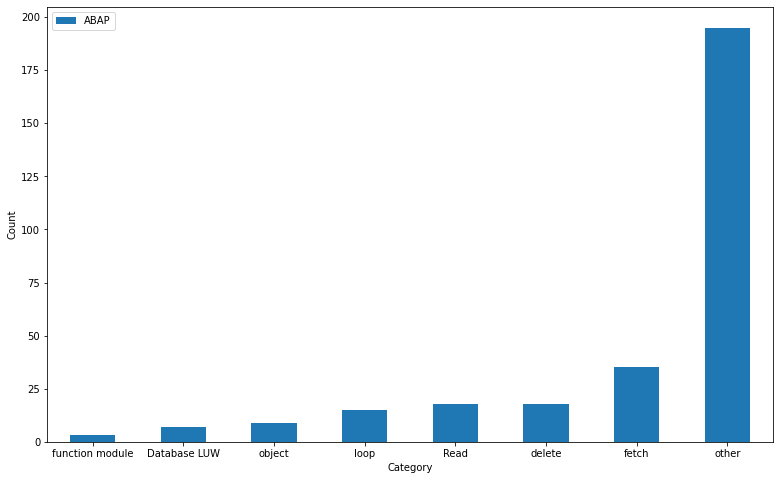

In [9]:
dfg = df_new.groupby(['Category']).count().sort_values(by=['ABAP'], ascending=True)

dfg.plot(kind='bar', ylabel='Count',
         xlabel='Category', figsize=(13, 8))

plt.xticks(rotation=0)

In [10]:
print('Pseudo-code:\n',df['Pseudo Code'][2])
print('ABAP code:\n', df['ABAP(HANA) source code'][2])

Pseudo-code:
 Read data from internal table lt_vbap
ABAP code:
 read table lt_vbap from data(ls_data).
If sy-subrc = 0.
endif.


In [11]:
stop_words = stopwords = set(stopwords.words('english'))

In [12]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [13]:
print(len(stop_words))

179


In [14]:
key_words = ['internal', 'table', 'function', 'module', 'class', 'object', 
            'replace', 'single', 'do', 'loop', 'error', 'index', 'message', 'leave', 'commit', 'call']
key_words

['internal',
 'table',
 'function',
 'module',
 'class',
 'object',
 'replace',
 'single',
 'do',
 'loop',
 'error',
 'index',
 'message',
 'leave',
 'commit',
 'call']

In [15]:
stop_words.update(key_words)

In [16]:
def word_synonym_aug(word):
    aug = naw.SynonymAug(aug_src='wordnet',aug_min=1, aug_max=3, stopwords=stop_words)
    return aug.augment(word,n=5)

In [17]:
org_pse = df['Pseudo Code'][2].lower()
org_pse

'read data from internal table lt_vbap'

In [18]:
word_synonym_aug(org_pse)

['translate data point from internal table lt_vbap',
 'record information from internal table lt_vbap',
 'record data from internal table lt_vbap',
 'read information from internal table lt_vbap',
 'record data point from internal table lt_vbap']

In [19]:
val = len(df)
for i in range(val):
    val1 = word_synonym_aug(df['Pseudo Code'][i])
    val2 = df['ABAP(HANA) source code'][i]
    for j in val1:
        val = j
        df1 = pd.DataFrame({"Pseudo Code":[val],"ABAP(HANA) source code":[val2]})
        df = df.append(df1, ignore_index=True)
df

,Pseudo Code,ABAP(HANA) source code
0,Read from internal table lt_mara to get the data,read table lt_mara from data(ls_data).\nIf sy-...
1,Fetch data from ZMARA using inner join ZMAKTX ...,select * from zmara inner join zmaktx on zmakt...
2,Read data from internal table lt_vbap,read table lt_vbap from data(ls_data).\nIf sy-...
3,Move data of one table to another table,move-corresponding lt_tab1 to lt_tab2.
4,loop over internal table lt_cust to get the data,loop at lt_cust into data(ls_data).\nEndloop.
...,...,...
1795,adjudge a stock internal table,data: lt_table type standard table of ztable.
1796,adjudge a received internal table,data: lt_table type standard table of ztable.
1797,adjudge a stock internal table,data: lt_table type standard table of ztable.
1798,hold a stock internal table,data: lt_table type standard table of ztable.


In [20]:
df.shape

(1800, 2)

In [21]:
df = df.drop_duplicates(['Pseudo Code'])

In [22]:
df.shape

(1367, 2)

In [23]:
df['ABAP(HANA) source code'][4]

'loop at lt_cust into data(ls_data).\nEndloop.'

In [24]:
df['ABAP(HANA) source code'][2]

'read table lt_vbap from data(ls_data).\nIf sy-subrc = 0.\nendif.'

#### io.BytesIO tokenization and untokenization procedure:

In [25]:
def tokenize_ABAP_code_io(python_code_str):
    python_tokens = list(tokenize(io.BytesIO(python_code_str.encode('utf-8')).readline))
    tokenized_output = []
    for i in range(0, len(python_tokens)):
        tokenized_output.append((python_tokens[i].type, python_tokens[i].string))
    return tokenized_output

In [26]:
tokenized_sample = tokenize_ABAP_code_io(df['ABAP(HANA) source code'][4])
print(tokenized_sample)
print(untokenize(tokenized_sample).decode('utf-8'))

[(62, 'utf-8'), (1, 'loop'), (1, 'at'), (1, 'lt_cust'), (1, 'into'), (1, 'data'), (54, '('), (1, 'ls_data'), (54, ')'), (54, '.'), (4, '\n'), (1, 'Endloop'), (54, '.'), (4, ''), (0, '')]
loop at lt_cust into data (ls_data ).
Endloop .


In [27]:
tokenized_sample = tokenize_ABAP_code_io(df['ABAP(HANA) source code'][2])
print(tokenized_sample)
print(untokenize(tokenized_sample).decode('utf-8'))

[(62, 'utf-8'), (1, 'read'), (1, 'table'), (1, 'lt_vbap'), (1, 'from'), (1, 'data'), (54, '('), (1, 'ls_data'), (54, ')'), (54, '.'), (4, '\n'), (1, 'If'), (1, 'sy'), (54, '-'), (1, 'subrc'), (54, '='), (2, '0.'), (4, '\n'), (1, 'endif'), (54, '.'), (4, ''), (0, '')]
read table lt_vbap from data (ls_data ).
If sy -subrc =0. 
endif .


#### WhitespaceTokenizer tokenization and TreebankWordDetokenizer for untokenization procedure:

In [28]:
def tokenize_ABAP_code(python_code_str):
    from nltk.tokenize import WhitespaceTokenizer    
    tknzr = WhitespaceTokenizer()
    tokenized_output = tknzr.tokenize(python_code_str)
    return tokenized_output

In [29]:
def untokenized(tokens):
    reconstructedSentence = TreebankWordDetokenizer().detokenize(tokens)
    reconstructedSentence = reconstructedSentence
    return reconstructedSentence

In [30]:
tokenized_sample = tokenize_ABAP_code(df['ABAP(HANA) source code'][4])
print(tokenized_sample)
print(untokenized(tokenized_sample))

['loop', 'at', 'lt_cust', 'into', 'data(ls_data).', 'Endloop.']
loop at lt_cust into data(ls_data). Endloop.


In [31]:
tokenized_sample = tokenize_ABAP_code(df['ABAP(HANA) source code'][2])
print(tokenized_sample)
print(untokenized(tokenized_sample))

['read', 'table', 'lt_vbap', 'from', 'data(ls_data).', 'If', 'sy-subrc', '=', '0.', 'endif.']
read table lt_vbap from data(ls_data). If sy-subrc = 0. endif.


In [32]:
python_problems_df = df

In [33]:
python_problems_df.shape

(1367, 2)

In [ ]:
def word_freq(val):
    words_ns = []
    for word in val:
    # typecaste each val to string
        val = str(word)
 
    # split the value
        tokens = val.split()
    
    # Converts each token into lowercase
        for i in range(len(tokens)):
            new = tokens[i].lower()     
            if new not in stopwords:
                words_ns.append(new)   
            
    #import seaborn as sns
    #%matplotlib inline
    #sns.set(rc={'figure.figsize':(5,5)},)
    #sns.set_style('darkgrid')
    nlp_words = nltk.FreqDist(words_ns)    
    nlp_words.plot(20,cumulative=False)      
    nlp_words.tabulate(5)        

In [ ]:
word_freq(python_problems_df['Pseudo Code']) 
word_freq(python_problems_df['ABAP(HANA) source code'])

In [ ]:
Input = data.Field(tokenize = 'spacy',
            init_token='<sos>', 
            eos_token='<eos>', 
            lower=True)

Output = data.Field(tokenize = tokenize_ABAP_code,
                    init_token='<sos>', 
                    eos_token='<eos>', 
                    lower=False)

In [ ]:
np.random.seed(0)
msk = np.random.rand(len(python_problems_df)) < 0.85 # Splitting data into 85% train and 15% validation

train_df = python_problems_df[msk]
val_df = python_problems_df[~msk]

In [ ]:
print(train_df.shape[0])
print(val_df.shape[0])

In [ ]:
SEED = 1234
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
fields = [('Input', Input),('Output', Output)]
fields

In [ ]:
train_example = []
val_example = []

#train_expansion_factor = 100
#for j in range(train_expansion_factor):
for i in range(train_df.shape[0]):
    try:
        ex = data.Example.fromlist([train_df['Pseudo Code'][i], train_df['ABAP(HANA) source code'][i]], fields)
        train_example.append(ex)
    except:
         pass

for i in range(val_df.shape[0]):
    try:
        ex = data.Example.fromlist([val_df['Pseudo Code'][i], val_df['ABAP(HANA) source code'][i]], fields)        
        val_example.append(ex)
    except:
        pass  

In [ ]:
train_data = data.Dataset(train_example, fields)
valid_data = data.Dataset(val_example, fields)

In [ ]:
Input.build_vocab( train_data, min_freq = 0)
Output.build_vocab(train_data, min_freq = 0)

In [ ]:
vocab = Input.vocab
vocab

In [ ]:
def save_vocab(vocab, path):
    output = open(path, 'wb')
    pickle.dump(vocab, output)
    output.close()

In [ ]:
len(Input.vocab)

In [ ]:
len(Output.vocab)

### Data visulization

In [ ]:
def word_cloud(word_df):
    comment_words = ''

# iterate through the csv file
    for val in word_df:
     
        # typecaste each val to string
        val = str(val)
 
        # split the value
        tokens = val.split()
     
        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        comment_words += " ".join(tokens)+" "
 
    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.show()

In [ ]:
word_cloud(python_problems_df['Pseudo Code']) 
word_cloud(python_problems_df['ABAP(HANA) source code'])

In [ ]:
top_df = python_problems_df[:200]
fig = px.treemap(top_df, title='Treemap',
                 path=['ABAP(HANA) source code','Pseudo Code'], 
                 color='Pseudo Code',
                 color_continuous_scale='RdBu')
                 
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

In [ ]:
df_1 = python_problems_df 
df_1['ABAP(HANA) source code']=df_1['ABAP(HANA) source code'].astype('category').cat.codes
df_1['Pseudo Code']=df_1['Pseudo Code'].astype('category').cat.codes
corr = df_1.corr()
sns.heatmap(corr,linecolor='blue')
corr.style.background_gradient(cmap='coolwarm')

In [ ]:
plt.scatter(python_problems_df['ABAP(HANA) source code'], python_problems_df['Pseudo Code'], label= "ABAP vs Pseudo", 
             s=20, cmap = 'viridis', c='blue')
  
# x-axis label
plt.xlabel('ABAP(HANA) source code')
# frequency label
plt.ylabel('Pseudo Code')
# plot title
plt.title('Scatter plot')
# showing legend
plt.legend()
  
# function to show the plot
plt.show()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

#### Encoder-Decoder, Multihead attention, Positional forward network

In [ ]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 1000):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]

        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

In [ ]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

In [ ]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

In [ ]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 10000):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        # query, key, value
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

In [ ]:
len(Input.vocab)

In [ ]:
len(Output.vocab)

In [ ]:
INPUT_DIM = len(Input.vocab)
OUTPUT_DIM = len(Output.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 16
DEC_HEADS = 16
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

LEARNING_RATE = 0.0005

In [ ]:

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [ ]:
SRC_PAD_IDX = Input.vocab.stoi[Input.pad_token]
TRG_PAD_IDX = Output.vocab.stoi[Output.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [ ]:
model.apply(initialize_weights);

In [ ]:


optimizer = torch.optim.Adam(model.parameters(
    

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(tqdm(iterator)): #enumerate(iterator):
        
        src = batch.Input.permute(1, 0)
        trg = batch.Output.permute(1, 0)
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(tqdm(iterator)): #enumerate(iterator):

            src = batch.Input.permute(1, 0)
            trg = batch.Output.permute(1, 0)

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 50
CLIP = 1

best_valid_loss = float('inf')

epoch_loss = pd.DataFrame()

for epoch in range(N_EPOCHS):
    
    start_time = time.time()

    train_example = []
    val_example = []

    for i in range(train_df.shape[0]):
        try:
            ex = data.Example.fromlist([train_df['Pseudo Code'][i], train_df['ABAP(HANA) source code'][i]], fields)
            train_example.append(ex)
        except:
            pass

    for i in range(val_df.shape[0]):
        try:
            ex = data.Example.fromlist([val_df['Pseudo Code'][i], val_df['ABAP(HANA) source code'][i]], fields)
            val_example.append(ex)
        except:
            pass       

    train_data = data.Dataset(train_example, fields)
    valid_data =  data.Dataset(val_example, fields)
    
    BATCH_SIZE = 16
    train_iterator, valid_iterator = BucketIterator.splits((train_data, valid_data), batch_size = BATCH_SIZE, 
                                                                sort_key = lambda x: len(x.Input),
                                                                sort_within_batch=True, device = device)
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    df_epoch   = pd.DataFrame({"Epoch":[epoch+1],"Val_Loss":[valid_loss], "Train_Loss":[train_loss]})
    epoch_loss = epoch_loss.append(df_epoch, ignore_index = True)  

In [ ]:
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss = evaluate(model, valid_iterator, criterion)

print(f'| Test  Loss: {test_loss:.3f} | Test  PPL: {math.exp(test_loss):7.3f} |')

In [ ]:
plt.plot(epoch_loss["Train_Loss"], 'g', label='Training loss')
plt.plot(epoch_loss["Val_Loss"], 'b', label='Testing loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
SRC = Input
TRG = Output

In [ ]:
def MaxMinWords(paragraph):
    numWords = [len(sentence.split()) for sentence in paragraph.split('.')]
    return max(numWords), min(numWords)

In [ ]:
df['ABAP(HANA) source code'][1]

In [ ]:
for i in df['ABAP(HANA) source code']:
    print(df['ABAP(HANA) source code'][i])
    max, min = MaxMinWords(df['ABAP(HANA) source code'][i])
    print(max,min)
    

In [ ]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 1000):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('en')
        tokens = [token.text.lower() for token in nlp(sentence)]
        #print(tokens)
    else:
        tokens = [token.lower() for token in sentence]
        #print(tokens)

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    #print(tokens)
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    #print(src_indexes)

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)
        #print(enc_src)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    #print(trg_tokens)
    
    return trg_tokens[1:], attention

In [ ]:
def val_p(text):    
    p = "([i|l|g|y|z]\w+)"
    result = re.findall(p, text,re.IGNORECASE)
    val = []
    for i in result:
        if i.find('_') != -1: 
            val.append(i.upper()) 
            
    return val

In [ ]:
def val_a(act_var,text):
    new_doc = ''
    new_doc = text.strip('<eos>').rstrip(" ")
    doc = nlp(text)
    expression = r"(((i|l|g)t)|z)\w+"
    for i in act_var:        
        for match in re.finditer(expression, doc.text,re.IGNORECASE):
            start, end = match.span()
            span = doc.char_span(start, end)
    
            if span is not None:  
                ##print(span.text)
                new_doc = new_doc.replace(span.text,i)
            
    return new_doc  

In [ ]:
def conv(text, actual_abap_code):
    src = act_text = text
    src=src.split(" ")
    translation, attention = translate_sentence(src, SRC, TRG, model, device)
    print(f'predicted trg sequence: ')
    print(translation)
    generated_code = untokenized(translation)
#generated_code = untokenize(translation[:-1]).decode('utf-8')
#print("code: \n", generated_code)
    generated_code = generated_code.replace('<eos>', "")
    print("code:\n", generated_code)    
    rev_generated_code = val_a(val_p(act_text),generated_code)
    print("Revised code:\n", rev_generated_code)
    data = [[actual_abap_code,rev_generated_code]]
    df2 = pd.DataFrame(data, columns=['Actual ABAP code ref', 'Generated ABAP Code'])
    new = rev_generated_code.split(" ")
    a = new
    a = a.append('<eos>')
    return  df2,src,new, attention

In [ ]:
def bleu_score(ref_code,generated_code):
    ref = ref_code.upper()
    ref = ref.split(" ")
    print('ABAP Code ref:\n', ref)

    src = generated_code.upper()
    src=src.split(" ")
    print('Generated Code\n',src)

    reference = [ref]
    candidate = src

##w/o smoothing function
    score = sentence_bleu(reference, candidate)
    print('BLEU score w/o smoothing-> {}'.format(score))

##Smoothing function
    score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25), smoothing_function=nltk.translate.bleu_score.SmoothingFunction().method7)
    print('BLEU score with smoothing-> {}'.format(score))

    print('Individual 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
    print('Individual 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 1, 0, 0)))
    print('Individual 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 1, 0)))
    print('Individual 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 0, 1)))

In [ ]:
def rouge_score(ref_code,generated_code):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rouge3', 'rougeL'], use_stemmer=True)
    scores = scorer.score(ref_code,generated_code)
    print('Rouge score\n', scores)

In [ ]:
def normalize_text(s):
    """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
    import string, re

    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

In [ ]:
def compute_exact_match(prediction, truth):
    print('Exact match\n', int(normalize_text(prediction) == normalize_text(truth))) 

In [ ]:
def display_attention(sentence, translation, attention, n_heads = 1, n_rows = 1, n_cols = 1):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(8,6))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='viridis')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

#### Example 1:

In [ ]:
actual_pseudo_code = actual_abap_code = ''
actual_pseudo_code = "Write class object ZCL_TEST"
actual_abap_code   = "DATA: lo_ref of ref to ZCL_TEST. CREATE Object: lo_ref." 
df2,src, translation, attention = conv(actual_pseudo_code,actual_abap_code)
ref = df2['Actual ABAP code ref'][0]
generated = df2['Generated ABAP Code'][0]
bleu_score(ref,generated)
rouge_score(ref,generated)
compute_exact_match(ref,generated)
display_attention(src, translation, attention)

#### Example 2:

In [ ]:
actual_pseudo_code = actual_abap_code = ''
actual_pseudo_code = "Check lines of table lt_zdest"
actual_abap_code   = "if lines(lt_zdest) EQ 0. Endif." 
df2,src, translation, attention = conv(actual_pseudo_code,actual_abap_code)
ref = df2['Actual ABAP code ref'][0]
generated = df2['Generated ABAP Code'][0]
bleu_score(ref,generated)
rouge_score(ref,generated)
compute_exact_match(ref,generated)
display_attention(src, translation, attention)

#### Example 3:

In [ ]:
actual_pseudo_code = actual_abap_code = ''
actual_pseudo_code = "Write function module z_fm1"
actual_abap_code   = "call function 'Z_FM1'." 
df2,src, translation, attention = conv(actual_pseudo_code,actual_abap_code)
ref = df2['Actual ABAP code ref'][0]
generated = df2['Generated ABAP Code'][0]
bleu_score(ref,generated)
rouge_score(ref,generated)
compute_exact_match(ref,generated)
display_attention(src, translation, attention)

#### Example 4:

In [ ]:
actual_pseudo_code = actual_abap_code = ''
actual_pseudo_code = "remove duplicate data from lt_data"
actual_abap_code   = "delete adjacent duplicates from lt_data." 
df2,src, translation, attention = conv(actual_pseudo_code,actual_abap_code)
ref = df2['Actual ABAP code ref'][0]
generated = df2['Generated ABAP Code'][0]
bleu_score(ref,generated)
rouge_score(ref,generated)
compute_exact_match(ref,generated)
display_attention(src, translation, attention)

#### Example 5:

In [ ]:
actual_pseudo_code = actual_abap_code = ''
actual_pseudo_code = "Read information from the internal table lt_xyz"
actual_abap_code   = "read table lt_xyz from data(ls_data). If sy-subrc = 0. endif." 
df2,src, translation, attention = conv(actual_pseudo_code,actual_abap_code)
ref = df2['Actual ABAP code ref'][0]
generated = df2['Generated ABAP Code'][0]
bleu_score(ref,generated)
rouge_score(ref,generated)
compute_exact_match(ref,generated)
display_attention(src, translation, attention)

#### Example 6:

In [ ]:
actual_pseudo_code = actual_abap_code = ''
actual_pseudo_code = "fetch date into a variable"
actual_abap_code   = "data(lv_date) = sy-datum." 
df2,src, translation, attention = conv(actual_pseudo_code,actual_abap_code)
ref = df2['Actual ABAP code ref'][0]
generated = df2['Generated ABAP Code'][0]
bleu_score(ref,generated)
rouge_score(ref,generated)
compute_exact_match(ref,generated)
display_attention(src, translation, attention)

#### Example 7:

In [ ]:
actual_pseudo_code = actual_abap_code = ''
actual_pseudo_code = "remove leading zero from lv_data"
actual_abap_code   = "SHIFT lv_data LEFT DELETING LEADING '0'." 
df2,src, translation, attention = conv(actual_pseudo_code,actual_abap_code)
ref = df2['Actual ABAP code ref'][0]
generated = df2['Generated ABAP Code'][0]
bleu_score(ref,generated)
rouge_score(ref,generated)
compute_exact_match(ref,generated)
display_attention(src, translation, attention)

#### Example 8:

In [ ]:
actual_pseudo_code = actual_abap_code = ''
actual_pseudo_code = "Get single from Database"
actual_abap_code   = "SELECT SINGLE * FROM ztab INTO @DATA(ls_data)."
df2,src, translation, attention = conv(actual_pseudo_code,actual_abap_code)
ref = df2['Actual ABAP code ref'][0]
generated = df2['Generated ABAP Code'][0]
bleu_score(ref,generated)
rouge_score(ref,generated)
compute_exact_match(ref,generated)
display_attention(src, translation, attention)

#### Example 9:

In [ ]:
actual_pseudo_code = actual_abap_code = ''
actual_pseudo_code = "Generate exception"
actual_abap_code   = "raise exception e1."
df2,src, translation, attention = conv(actual_pseudo_code,actual_abap_code)
ref = df2['Actual ABAP code ref'][0]
generated = df2['Generated ABAP Code'][0]
bleu_score(ref,generated)
rouge_score(ref,generated)
compute_exact_match(ref,generated)
display_attention(src, translation, attention)

#### Example 10:

In [ ]:
actual_pseudo_code = actual_abap_code = ''
actual_pseudo_code = "Do commit to database."
actual_abap_code   = "commit work."
df2,src, translation, attention = conv(actual_pseudo_code,actual_abap_code)
ref = df2['Actual ABAP code ref'][0]
generated = df2['Generated ABAP Code'][0]
bleu_score(ref,generated)
rouge_score(ref,generated)
compute_exact_match(ref,generated)
display_attention(src, translation, attention)

#### Example 11:

In [ ]:
actual_pseudo_code = actual_abap_code = ''
actual_pseudo_code = "process over internal table lt_post to fetch data"
actual_abap_code   = "loop at lt_post into data(ls_data). Endloop."
df2,src, translation, attention = conv(actual_pseudo_code,actual_abap_code)
ref = df2['Actual ABAP code ref'][0]
generated = df2['Generated ABAP Code'][0]
bleu_score(ref,generated)
rouge_score(ref,generated)
compute_exact_match(ref,generated)
display_attention(src, translation, attention)